In [22]:
# Imports

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2, whiten

# Read in the dataset from oslobysykkel, and look for correlation between rows
year  = "2021"
month = "10"
URL = f"https://data.urbansharing.com/oslobysykkel.no/trips/v1/{year}/{month}.csv"
df = pd.read_csv(URL)
df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2021-10-01 03:03:09.586000+00:00,2021-10-01 03:08:19.084000+00:00,309,397,Storo Storsenter,langs Vitaminveien,59.946710,10.773805,393,Hans Nielsen Hauges plass,langs Hans Nielsen Hauges gate,59.939244,10.774319
1,2021-10-01 03:03:42.698000+00:00,2021-10-01 03:12:51.917000+00:00,549,583,Galgeberg,langs St. Halvards gate,59.907076,10.779164,585,Nordre gate,ved Grünerbrua,59.921150,10.754714
2,2021-10-01 03:07:18.929000+00:00,2021-10-01 03:16:44.444000+00:00,565,514,Sofienberggata,ved Sars gate,59.921206,10.769989,442,Vulkan,ved Maridalsveien,59.922510,10.751010
3,2021-10-01 03:07:43.339000+00:00,2021-10-01 03:18:25.719000+00:00,642,444,AHO,langs Maridalsveien,59.925265,10.750462,558,Dokkveien,ved Støperigata,59.910974,10.727700
4,2021-10-01 03:08:45.961000+00:00,2021-10-01 03:18:15.293000+00:00,569,446,Bislett Stadion,ved rundkjøringen,59.925471,10.731219,478,Jernbanetorget,Europarådets plass,59.911901,10.749929


In [23]:
# Preparing data

#Getting only unique stations ID'set
df = df.sort_values('start_station_id', ascending=False)
sdf = df.drop_duplicates(subset='start_station_name', keep='first')
sdf = sdf.sort_values('start_station_id', ascending=True)
sdf.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
18476,2021-10-05 20:03:53.528000+00:00,2021-10-05 20:07:58.342000+00:00,244,377,Tøyenparken,ved Caltexløkka,59.915667,10.777567,457,Trondheimsveien,ved trikkestoppet,59.923058,10.771719
79629,2021-10-18 13:42:35.077000+00:00,2021-10-18 14:08:04.556000+00:00,1529,378,Colosseum Kino,langs Fridtjof Nansens vei,59.929843,10.711285,627,Skøyen Stasjon,langs Hoffsveien,59.922724,10.678625
85377,2021-10-20 04:41:25.046000+00:00,2021-10-20 04:55:31.951000+00:00,846,380,Bentsebrugata,rett over busstoppet,59.939230,10.759170,558,Dokkveien,ved Støperigata,59.910974,10.727700
137743,2021-10-31 18:25:53.140000+00:00,2021-10-31 18:57:28.682000+00:00,1895,381,Grønlands torg,ved Tøyenbekken,59.912520,10.762240,580,Georg Morgenstiernes hus,ved Moltke Moes vei,59.939026,10.723003
45267,2021-10-11 16:35:24.986000+00:00,2021-10-11 16:53:14.148000+00:00,1069,382,Stensgata,ved trikkestoppet,59.929586,10.732839,460,Botanisk Hage sør,langs Jens Bjelkes gate,59.915418,10.769330


In [24]:
# Define a class to store stations in
class station:
    # instance method that initializes a newly created object.
    def __init__(self, id,longitude,latitude,name, change = 0, zone = 0):
            self.id = id
            self.long = longitude
            self.lat = latitude
            self.name = name
            self.change = change
            self.zone = zone
        
    def updateChange(self, tick):
        self.change += tick
    def setZone(self, zone):
        self.zone = zone
    def getZone(self):
        return self.zone        
    def getId(self):
        return self.id
    def getName(self):
        return self.name
    def getLongLat(self):
        return [self.long,self.lat]
    def getChange(self):
        return self.change
    def export(self):
        return [self.id,self.name,self.long,self.lat,self.change,self.zone]

In [25]:
# Put each station in a class object

#Assign each station to it's own station object
listOfStations=[]
for index, row in sdf.iterrows():
                    #id, latitude, longitude
    tmp = station(row[3], row[6], row[7], row[4])
    listOfStations.append(tmp)


# TRAIN SOME CLUSTERS

# Define amount of clusters we want
clusters = 5

# Export coordinates from each station to a coordinate list
cor = []
for station in listOfStations:
    cor.append(station.getLongLat())
coordinates = np.array(cor)

In [26]:
# We will now check two kmeans libraries

# 1: scipy.cluster.vq.kmeans2:
x, clust1 = kmeans2(whiten(coordinates), clusters, iter = 150) 
#x = center of cluster
#clust1 = what item belong to what cluster

# 2: sklearn.cluster.KMeans
kmeans = KMeans(n_clusters=clusters, random_state=0, max_iter=150).fit(coordinates)
clust2 = kmeans.labels_

c:\Users\G\miniconda3\envs\lab-1\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\G\miniconda3\envs\lab-1\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [29]:
# Plot to see the difference

#defined plot differently. Was having issues with Seaborn. Used Matplotlib instead.
def plot_cluster(cluster):
    sns.set(rc={'figure.figsize':(15,10)})
    plt.scatter(coordinates[:,0], coordinates[:,1], c=cluster, cmap='viridis')
    plt.title("Stations clustered by kmeans", fontsize=20)
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel('Longitude', fontsize=12)
    plt.colorbar()


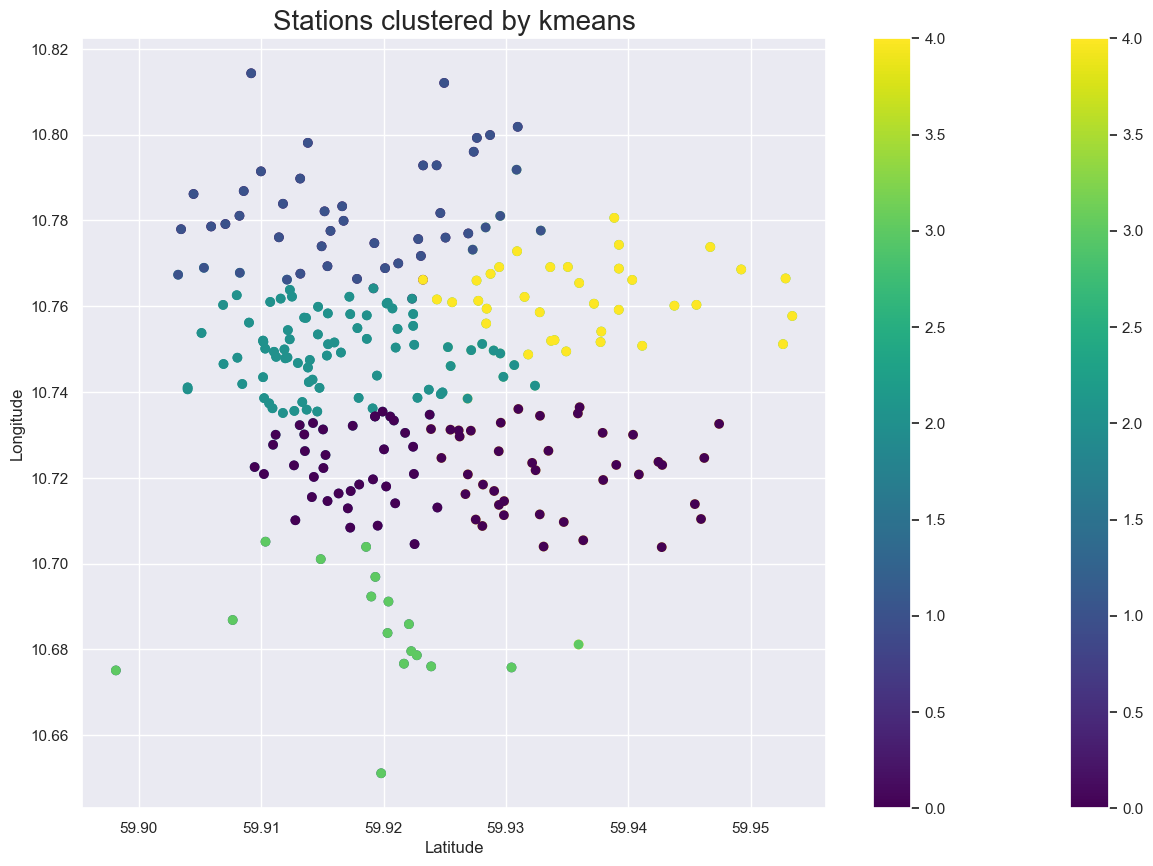

In [30]:
# Plot1:
plot_cluster(clust1)

# Plot2:
plot_cluster(clust2)

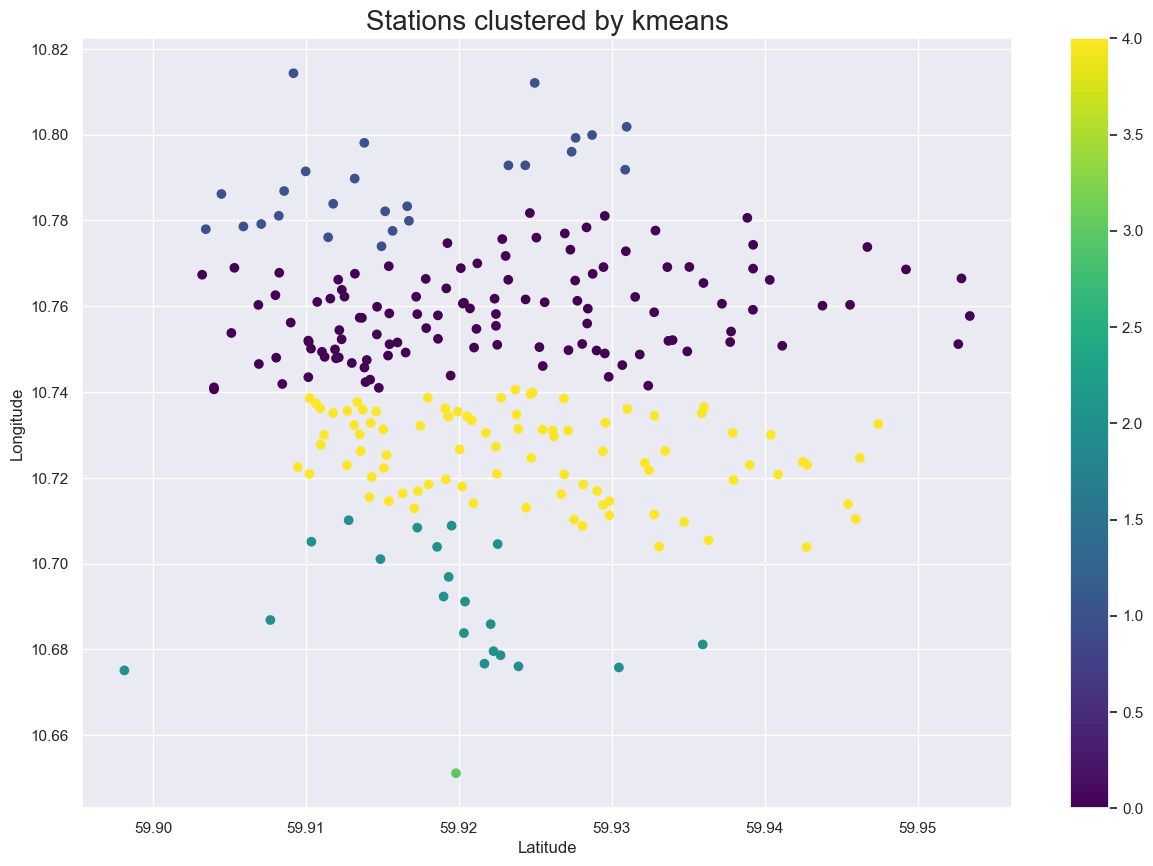

In [31]:
# Can also check with other clustering methods by changing one line

#Different linking methods 'ward', 'average', 'complete', 'single'   
from sklearn.cluster import AgglomerativeClustering 
newAlg = AgglomerativeClustering(linkage = 'average', n_clusters=clusters)
newAlg.fit(coordinates)
clust3=newAlg.labels_

plot_cluster(clust3)

In [ ]:
# VISUALIZE THE DATA